==== Solid Red-ish ====


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


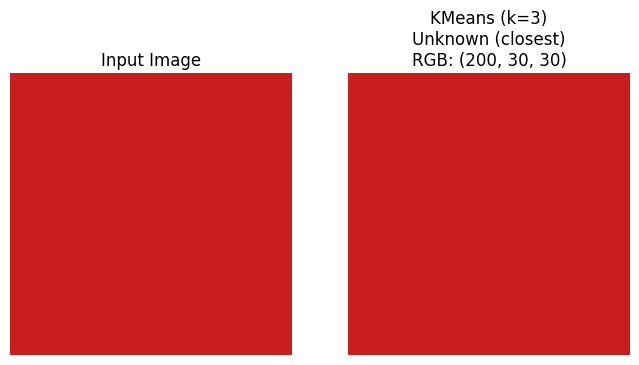

KMeans: Unknown, RGB: (200, 30, 30)


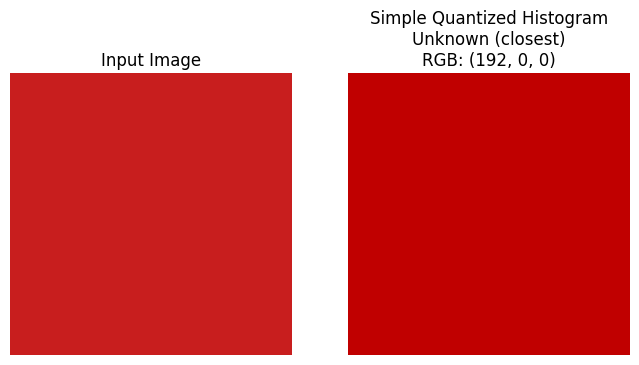

Simple: Unknown, RGB: (192, 0, 0)
Saved swatches to color_detection_outputs

==== Multi Blocks ====


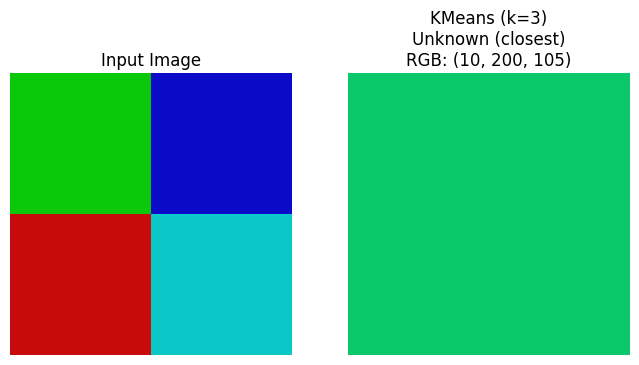

KMeans: Unknown, RGB: (10, 200, 105)


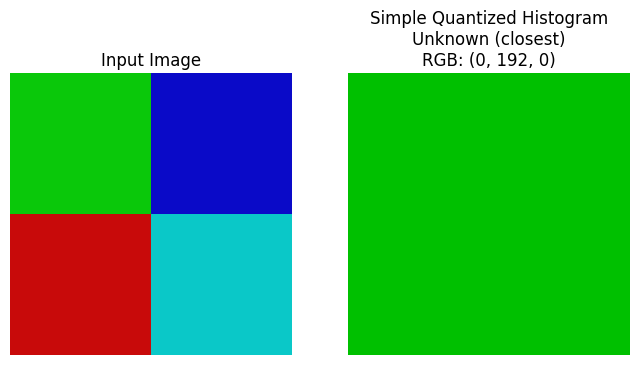

Simple: Unknown, RGB: (0, 192, 0)
Saved swatches to color_detection_outputs

==== Gradient ====


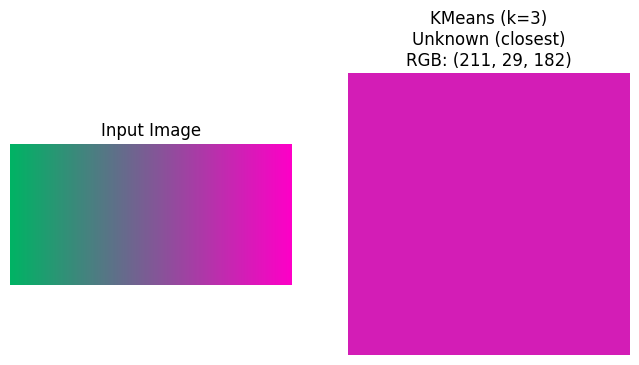

KMeans: Unknown, RGB: (211, 29, 182)


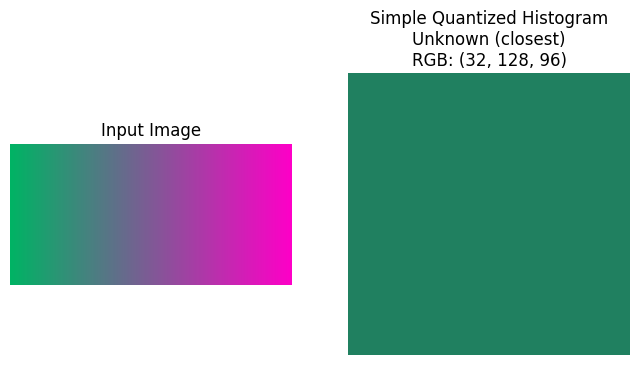

Simple: Unknown, RGB: (32, 128, 96)
Saved swatches to color_detection_outputs

Done. All images processed without uploads or downloads.


In [3]:
# Color Detection WITHOUT uploads or downloads
# Paste and run this whole cell in Google Colab or a Python environment.
# Installs needed packages if missing (Colab-friendly).
!pip install --quiet opencv-python-headless matplotlib scikit-learn webcolors pillow

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
from PIL import Image
import webcolors
import os

# -----------------------
# Helper functions
# -----------------------
def bgr2rgb(color_bgr):
    return (int(color_bgr[2]), int(color_bgr[1]), int(color_bgr[0]))

def closest_color_name(requested_rgb):
    """Return (name, exact_flag). Robust to webcolors version differences."""
    try:
        name = webcolors.rgb_to_name(requested_rgb, spec='css3')
        return name, True
    except Exception:
        if hasattr(webcolors, 'CSS3_NAMES_TO_HEX'):
            name_to_hex = webcolors.CSS3_NAMES_TO_HEX
        elif hasattr(webcolors, 'css3_hex_to_names'):
            hex_to_name = webcolors.css3_hex_to_names
            name_to_hex = {v: k for k, v in hex_to_name.items()}
        else:
            name_to_hex = getattr(webcolors, 'HTML4_NAMES_TO_HEX', {})
        min_dist = float('inf')
        closest = None
        for nm, hexval in name_to_hex.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(hexval)
            dist = (r_c - requested_rgb[0])**2 + (g_c - requested_rgb[1])**2 + (b_c - requested_rgb[2])**2
            if dist < min_dist:
                min_dist = dist
                closest = nm
        return (closest if closest is not None else "Unknown", False)

def dominant_color_kmeans(image_bgr, k=4, resize_for_speed=True):
    img = image_bgr.copy()
    if resize_for_speed:
        h, w = img.shape[:2]
        max_dim = 600
        if max(h, w) > max_dim:
            scale = max_dim / max(h, w)
            img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    pixels = img.reshape(-1, 3)
    pixels = np.float32(pixels)
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(pixels)
    counts = Counter(labels)
    centers = kmeans.cluster_centers_.astype(int)
    dominant_idx = max(counts, key=counts.get)
    dominant_color_bgr = tuple(int(c) for c in centers[dominant_idx])
    return dominant_color_bgr, centers, counts

def dominant_color_simple(image_bgr):
    img = cv2.resize(image_bgr.copy(), (200,200), interpolation=cv2.INTER_AREA)
    pixels = img.reshape(-1, 3)
    quantized = (pixels // 32) * 32
    tuples = [tuple(p) for p in quantized]
    most_common = Counter(tuples).most_common(1)[0][0]
    return most_common

def show_result(image_bgr, color_bgr, method_name='Method'):
    color_rgb = bgr2rgb(color_bgr)
    color_name, exact = closest_color_name(color_rgb)
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Input Image')
    plt.subplot(1,2,2)
    swatch = np.zeros((160,160,3), dtype=np.uint8)
    swatch[:,:] = color_bgr  # BGR
    swatch_rgb = cv2.cvtColor(swatch, cv2.COLOR_BGR2RGB)
    plt.imshow(swatch_rgb)
    plt.axis('off')
    match_text = f"{color_name} (exact)" if exact else f"{color_name} (closest)"
    plt.title(f'{method_name}\n{match_text}\nRGB: {color_rgb}')
    plt.show()
    return color_name, color_rgb

# -----------------------
# Build synthetic images (BGR)
# -----------------------
# 1) Solid color (strong red)
solid_bgr = np.zeros((300,300,3), dtype=np.uint8)
solid_bgr[:] = (30, 30, 200)  # BGR: strong red-ish (OpenCV uses BGR)

# 2) Multi-block image (4 color blocks)
multi_bgr = np.zeros((300,300,3), dtype=np.uint8)
h,w = 300,300
multi_bgr[0:150,0:150] = (10,200,10)    # green block
multi_bgr[0:150,150:300] = (200,10,10)  # red block
multi_bgr[150:300,0:150] = (10,10,200)  # blue block
multi_bgr[150:300,150:300] = (200,200,10)# yellow-ish block

# 3) Gradient image (left->right)
grad = np.zeros((200,400,3), dtype=np.uint8)
for x in range(400):
    r = int((x/399)*255)
    g = int((1 - x/399)*180)
    b = int(100 + (x/399)*100)
    grad[:,x] = (b,g,r)  # assign BGR

# Prepare a list
images = [
    ("Solid Red-ish", solid_bgr),
    ("Multi Blocks", multi_bgr),
    ("Gradient", grad)
]

# Create output directory for saved swatches
out_dir = "color_detection_outputs"
os.makedirs(out_dir, exist_ok=True)

# -----------------------
# Run detection on each image
# -----------------------
for title, img_bgr in images:
    print("====", title, "====")
    # KMeans
    dom_k_bgr, centers, counts = dominant_color_kmeans(img_bgr, k=3)
    name_k, rgb_k = show_result(img_bgr, dom_k_bgr, method_name='KMeans (k=3)')
    print(f"KMeans: {name_k}, RGB: {rgb_k}")
    # Simple
    dom_s_bgr = dominant_color_simple(img_bgr)
    name_s, rgb_s = show_result(img_bgr, dom_s_bgr, method_name='Simple Quantized Histogram')
    print(f"Simple: {name_s}, RGB: {rgb_s}")
    # Save swatches
    sw_k = np.zeros((100,100,3), dtype=np.uint8); sw_k[:,:] = dom_k_bgr
    sw_s = np.zeros((100,100,3), dtype=np.uint8); sw_s[:,:] = dom_s_bgr
    cv2.imwrite(os.path.join(out_dir, f"{title.replace(' ','_')}_kmeans.png"), sw_k)
    cv2.imwrite(os.path.join(out_dir, f"{title.replace(' ','_')}_simple.png"), sw_s)
    print(f"Saved swatches to {out_dir}\n")

print("Done. All images processed without uploads or downloads.")
